<a href="https://colab.research.google.com/github/smart-able/Pepper-disease/blob/main/pepper_still.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import auth
auth.authenticate_user()


from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!cd "/content/drive/My Drive/pepper"; ls -l

total 12
drwx------ 2 root root 4096 Feb  3 03:12 aihub
drwx------ 2 root root 4096 Jan  3 04:36 Training
drwx------ 2 root root 4096 Jan  3 04:36 Validation


In [2]:
import tensorflow as tf

import cv2
import os
import zipfile
import random
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib.image as mpimg
import tensorflow.keras

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [3]:
composed = transforms.Compose([
                    transforms.ToTensor(), #Numpy-> Tensor
                    transforms.Normalize((0.1,), (0.3,))]) # Normalize : 표준 정규분포로 바꿔줌 0~255 데이터 --> 평균 0.1, 표준편차 0.3 으로 맞춰줌

In [ ]:
# Unzip Training
local_zip = '/content/drive/My Drive/pepper/Training/raw_health.zip'
zip_ref = zipfile.ZipFile(local_zip,'r')
zip_ref.extractall('/content/drive/My Drive/pepper/Training/raw_health')
zip_ref.close()

# Unzip Validation
local_zip = '/content/drive/My Drive/pepper/Validation/raw_health.zip'
zip_ref = zipfile.ZipFile(local_zip,'r')
zip_ref.extractall('/content/drive/My Drive/pepper/Validation/raw_health')
zip_ref.close()

KeyboardInterrupt: ignored

In [4]:
# Directory with our training health pictures
train_health_dir = os.path.join('/content/drive/My Drive/pepper/Training/raw_health')
train_health_leaf_dir = os.path.join('/content/drive/My Drive/pepper/Training/raw_health_leaf')
# Directory with our training disease pictures
train_anth_dir = os.path.join('/content/drive/My Drive/pepper/Training/raw_anthracnose')
train_notanth_dir = os.path.join('/content/drive/My Drive/pepper/Training/raw_powdery')

In [5]:
# Directory with our validation health pictures
validation_health_dir = os.path.join('/content/drive/My Drive/pepper/Validation/raw_health')
validation_health_leaf_dir = os.path.join('/content/drive/My Drive/pepper/Validation/raw_health_leaf')
# Directory with our validation anthracnose pictures
validation_anth_dir = os.path.join('/content/drive/My Drive/pepper/Validation/raw_anth')
validation_notanth_dir = os.path.join('/content/drive/My Drive/pepper/Validation/raw_powdery')

In [ ]:
#how many data
print('total training healthy images : ',len(os.listdir(train_health_dir)))
print('total training healthy leaf images : ',len(os.listdir(train_health_leaf_dir)))
print('total training anthracnose images : ',len(os.listdir(train_anth_dir)))
print('total training another disease images : ',len(os.listdir(train_notanth_dir)))

print('total validation healthy images : ',len(os.listdir(validation_health_dir)))
print('total validation healthy leaf images : ',len(os.listdir(validation_health_leaf_dir)))
print('total validation anthracnose images : ',len(os.listdir(validation_anth_dir)))
print('total validation another disease images : ',len(os.listdir(validation_notanth_dir)))

total training healthy images :  1958
total training healthy leaf images :  2068
total training anthracnose images :  973
total training another disease images :  915
total validation healthy images :  259
total validation healthy leaf images :  239
total validation anthracnose images :  118
total validation another disease images :  111


In [ ]:
# 데이터 할당
BATCH_SIZE = 128
IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256
CHANNELS = 3
training_dir = os.path.join('/content/drive/My Drive/pepper/Training')
validation_dir = os.path.join('/content/drive/My Drive/pepper/Validation')

# Training dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=training_dir,
    batch_size=BATCH_SIZE,
    validation_split=None,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
)
# Validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=validation_dir,
    batch_size=BATCH_SIZE,
    validation_split=None,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
)

Found 5914 files belonging to 4 classes.
Found 727 files belonging to 4 classes.


In [ ]:
print(train_ds.head(10))

SyntaxError: ignored

['raw_anthracnose', 'raw_health', 'raw_health_leaf', 'raw_powdery']


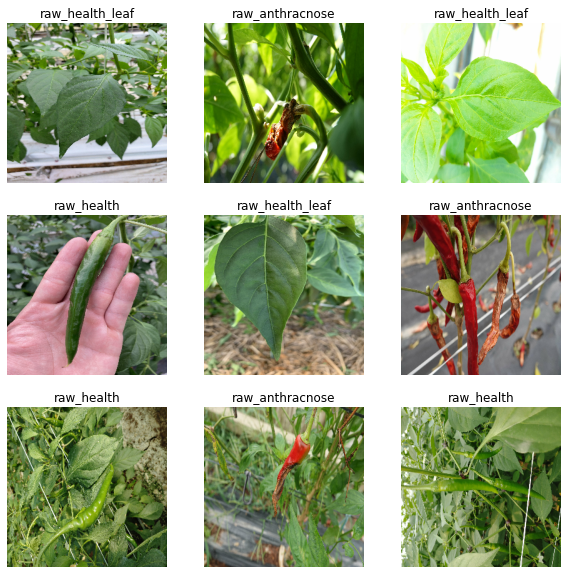

In [ ]:
# 데이터 시각화
class_names = train_ds.class_names
print(class_names)

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3,3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

https://www.youtube.com/watch?v=7ZOIbkA9eqI

In [ ]:
#BatchDataset to Numpy
import torch
from torch.utils.data import BatchDataset, DataLoader

# create a BatchDataset object
batch_dataset = BatchDataset(data=[torch.tensor([1, 2, 3]), torch.tensor([4, 5, 6]), torch.tensor([7, 8, 9])])

# create a DataLoader object to iterate over the dataset
data_loader = DataLoader(batch_dataset, batch_size=1)

# iterate over the DataLoader and convert the data to a tensor
for batch in data_loader:
    tensor_batch = torch.stack(batch)

print(tensor_batch)

<class 'tuple'>
----
<class 'tuple'>
----
<class 'tuple'>
----
<class 'tuple'>
----
<class 'tuple'>
----
<class 'tuple'>
----
<class 'tuple'>
----


KeyboardInterrupt: ignored

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
x_train = x_train.astype('float32') / 255.
x_validation = x_validation.astype('float32') / 255.

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [ ]:
train_ds = train_ds.astype("float32"/255)

AttributeError: ignored

In [ ]:
#모델 생성
num_classes = len(class_names)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu',input_shape=(256,256,3)),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes,activation='softmax')
])

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 32, 32, 64)       0

In [ ]:
history = model.fit(train_ds,
                    validation_data=val_ds,
                    label_mode="int",
                    epochs=5,
                    verbose=1)

TypeError: ignored

In [ ]:
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 300x300 with 3 bytes color
    tf.keras.layers.Conv2D(64,(3,3),activation='relu',input_shape=(256,256,3)),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.Conv2D(64,(3,3),activation='relu'),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.Conv2D(128,(3,3),activation='relu'),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.Conv2D(128,(3,3),activation='relu'),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512,activation='relu'),
    tf.keras.layers.Dense(3,activation='softmax')    
])

model.compile(optimizer='rmsprop',
             loss='categorical_crossentropy',
             metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 298, 298, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 149, 149, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 147, 147, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 73, 73, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 71, 71, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 35, 35, 128)      0

이미지 증강

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

TRAINING_DIR = '/content/drive/My Drive/pepper/Training'
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

VALIDATION_DIR = '/content/drive/My Drive/pepper/Validation'
test_datagen = ImageDataGenerator(rescale=1./255.)

train_generator = train_datagen.flow_from_directory(
                  TRAINING_DIR,
                  target_size=(300,300),
                  batch_size=126,
                  class_mode = 'categorical')

validation_generator = test_datagen.flow_from_directory(
                  VALIDATION_DIR,
                  target_size=(300,300),
                  batch_size=126,
                  class_mode = 'categorical')

Found 10463 images belonging to 3 classes.
Found 1339 images belonging to 3 classes.


In [ ]:
history = model.fit(train_generator,
                    validation_data=validation_generator,
                    # steps_per_epoch=20,    #  2520/126
                    epochs=25,
                    # validation_steps=3,    # 372/126
                    verbose=1)

Epoch 1/25


학습 결과 시각화

In [ ]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history.history[     'accuracy' ]
val_acc  = history.history[ 'val_accuracy' ]
loss     = history.history[    'loss' ]
val_loss = history.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'g', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

NameError: ignored